# Video Surveillance for Road Traffic Monitoring
## _Week 1: Background estimation_
***

In [19]:
import numpy as np
import cv2
import pickle

print("NumPy version:", np.__version__)
print("OpenCV version:", cv2.__version__)

# Newer versions of OpenCV and NumPy won't work with MOG and LSBP (Task 3)

NumPy version: 1.23.3
OpenCV version: 3.4.18


In [20]:
from src.task3 import remove_background_opencv
from src.postprocess import *
from src.metrics import *

In [21]:
# Path to the video file
vid_path = 'data/AICity_data/AICity_data/train/S03/c010/vdo.avi'

In [23]:
# Load ground truth annotations as a list of lists
gt_list = parse_gt_annotations('data/ai_challenge_s03_c010-full_annotation.xml')

# Save to a pickle file
with open('gt_annotations.pkl', 'wb') as f:
    pickle.dump(gt_list, f)

In [22]:
# Load ground truth
gt_list = pickle.load(open('gt_annotations.pkl', 'rb'))

In [ ]:
# Generate video of the ground truth bounding boxes
generate_bounding_box_video(gt_list, vid_path, 'output/gt_bboxes.avi', (0, 0, 255))

## Task 1.1. Gaussian modelling
***

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

def gaussian(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def plot_gaussian(sigma, alphas, color):
    mu = 0  # Media fija en 0
    x = np.linspace(-5 * sigma, 5 * sigma, 1000)
    y = gaussian(x, mu, sigma)
    
    plt.figure(figsize=(8, 6))
    plt.plot(x, y)
    
    # Rellenar áreas con colores semitransparentes
    plt.fill_between(x, y, where=(x >= mu - alphas * sigma) & (x <= mu + alphas * sigma), 
                     color='blue', alpha=0.1, label='Background')
    plt.fill_between(x, y, where=(x < mu - alphas * sigma) | (x > mu + alphas * sigma), 
                     color='red', alpha=0.2, label='Foreground')
    
    # Agregar líneas verticales en μ - ασ y μ + ασ con colores personalizados
    plt.axvline(mu - alphas * sigma, color=color, linestyle='solid', label=f'α = {alphas}', linewidth=3)
    plt.axvline(mu + alphas * sigma, color=color, linestyle='solid', linewidth=3)
    plt.axvline(mu, color='lightgray', linestyle='dashed', linewidth=1)
        
    plt.text(mu - alphas * sigma - 0.5, max(y) * 0.65, rf'$\mu - {alphas} \cdot \sigma$', horizontalalignment='right', fontsize=16, color=color)
    plt.text(mu + alphas * sigma + 0.5, max(y) * 0.65, rf'$\mu + {alphas} \cdot \sigma$', horizontalalignment='left', fontsize=16, color=color)

    # Eliminar los bordes del gráfico
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # Configuración del eje X
    plt.xticks([mu], ["μ"], fontsize=20)
    plt.yticks([])
    plt.legend(fontsize=17)
    
    # Guardar la imagen en un objeto BytesIO
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close()
    buf.seek(0)
    return Image.open(buf)

def create_gif(sigma, alphas, filename='gaussian_animation.gif', duration=1500):
    # Generar colores verdes de claro a oscuro
    colors = [plt.cm.Oranges(i / len(alphas)) for i in range(1, len(alphas) + 1)]
    
    frames = [plot_gaussian(sigma, alpha, color) for alpha, color in zip(alphas, colors)]
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)
    print(f'GIF guardado como {filename}')

# Crear el GIF con valores de α = 0.5, 1, 2, 3, 4
create_gif(sigma=1.0, alphas=[0.5, 1, 2, 3])

GIF guardado como gaussian_animation.gif


## Task 1.2. $\text{mAP}_{0.5}$ vs Alpha
***

## RGB Colorspace

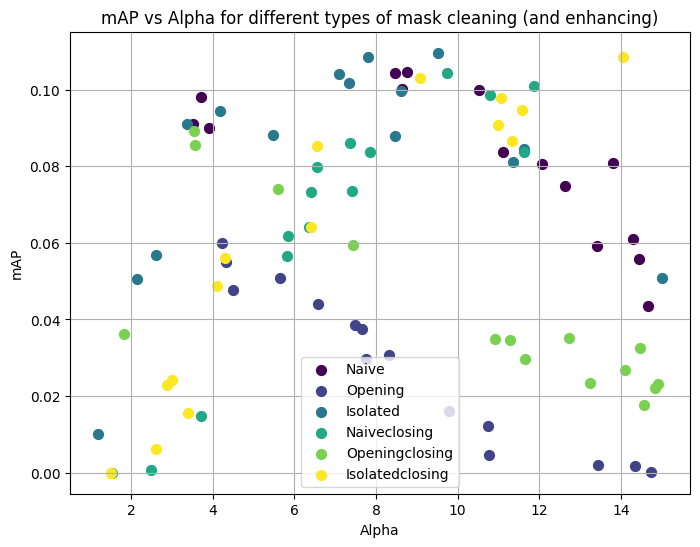

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_alpha_map(*file_paths):
    plt.figure(figsize=(8, 6))

    # Definir una lista de colores para diferenciar cada archivo
    colors = plt.cm.viridis(np.linspace(0, 1, len(file_paths)))

    for file_path, color in zip(file_paths, colors):
        alpha = []
        mAP = []

        with open(file_path, 'r') as f:
            next(f)  # Skip the first header line
            next(f)  # Skip the second header line

            # Read each line of the file and extract values
            for line in f:
                if line.strip():  # Ignore empty lines
                    parts = line.split()
                    alpha.append(float(parts[0]))
                    mAP.append(float(parts[1]))

        # Convert lists to numpy arrays for easier processing
        alpha = np.array(alpha)
        mAP = np.array(mAP)

        # Scatter plot for the current file
        label = file_path.split('_')[-1].replace('.txt', '').capitalize()
        plt.scatter(alpha, mAP, s=50, color=color, label=label)  

    # Labels, title, and legend
    plt.xlabel('Alpha')
    plt.ylabel('mAP')
    plt.title('mAP vs Alpha for different types of mask cleaning (and enhancing)')
    plt.grid(True)
    plt.legend()
    plt.show()

# Call the function with multiple files
plot_alpha_map('../task1_results_naive.txt', '../task1_results_opening.txt', '../task1_results_isolated.txt',
               '../task1_results_naiveClosing.txt', '../task1_results_openingClosing.txt', '../task1_results_isolatedClosing.txt')


## CieLAB colorspace

In [ ]:
# TODO

## Task 2.1. Adaptive modelling
***

#### Squares are results for the post-processing: Clean mask --> 'ISOLATED', enhance mask --> 'NAIVE'
#### Circles are results for the post-processing: Clean mask --> 'ISOLATED', enhance mask --> 'CLOSING'

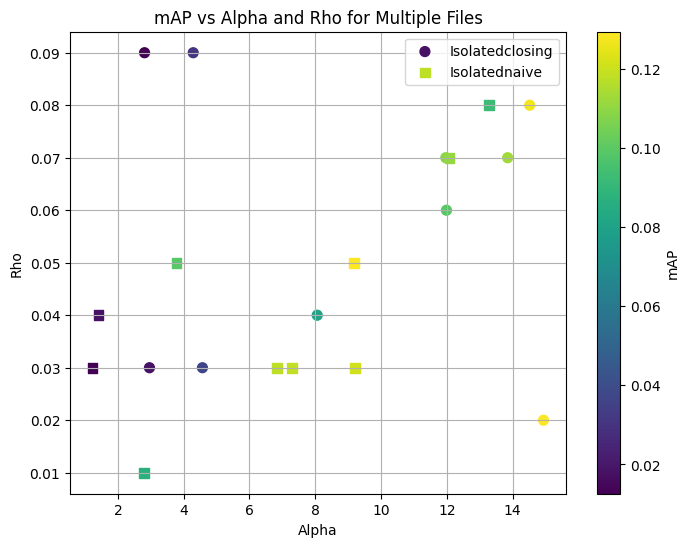

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(file_paths):
    # Define diferentes estilos de marcadores
    markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X']  # Puedes añadir más si es necesario
    marker_count = len(markers)

    plt.figure(figsize=(8, 6))

    for i, file_path in enumerate(file_paths):
        alpha = []
        rho = []
        mAP = []

        with open(file_path, 'r') as f:
            # Skip headers
            next(f) 
            next(f)  

            # Read each line of the file and extract values
            for line in f:
                if line.strip():  # Ignore empty lines
                    parts = line.split()
                    alpha.append(float(parts[0]))
                    rho.append(float(parts[1]))
                    mAP.append(float(parts[2]))

        # Convert lists to numpy arrays for easier operations
        alpha = np.array(alpha)
        rho = np.array(rho)
        mAP = np.array(mAP)

        # Plot data with a different marker for each file
        label = file_path.split('_')[-1].replace('.txt', '').capitalize()
        scatter = plt.scatter(alpha, rho, c=mAP, cmap='viridis', s=50, 
                              marker=markers[i % marker_count], label=label)

    plt.colorbar(scatter, label='mAP')  # Add color bar
    plt.xlabel('Alpha')
    plt.ylabel('Rho')
    plt.title('mAP vs Alpha and Rho for Multiple Files')
    plt.grid(True)
    plt.legend()  # Show legend for different files
    plt.show()

# Llama a la función con una lista de archivos de resultados
plot_results(['../task2_results_isolatedClosing.txt', '../task2_results_isolatedNaive.txt'])


## Task 2.2. Comparison of adaptive vs non-adaptive modelling
***

In [ ]:
# TODO

## Task 3. Comparison with state-of-the-art
***

[OpenCV Gaussian Mixture-based Background/Foreground Segmentation (I)](https://docs.opencv.org/3.4.0/d6/da7/classcv_1_1bgsegm_1_1BackgroundSubtractorMOG.html)

In [ ]:
# Remove background using MOG
remove_background_opencv(vid_path, "output/mask_output_MOG.avi", method="MOG")

# Denoise the mask
remove_noise("output/mask_output_MOG.avi", "output/mask_output_MOG_denoised.avi", kernel_size=3)

# Extract bounding boxes from the video
pred_bboxes_MOG = get_bounding_boxes("output/mask_output_MOG_denoised.avi")

# Apply NMS
pred_bboxes_MOG_nms = non_max_suppression(pred_bboxes_MOG)

# Save predictions in a pickle file
with open('pred_bboxes_MOG.pkl', 'wb') as f:
    pickle.dump(pred_bboxes_MOG_nms, f)

Binary mask video generated. Output saved to: output/mask_output_MOG.avi
Denoised mask video saved at: output/mask_output_MOG_denoised.avi


In [ ]:
# Load predictions from the pickle file
pred_bboxes_MOG = pickle.load(open('pred_bboxes_MOG.pkl', 'rb'))

In [ ]:
# Compute AP
ap50 = compute_AP(pred_bboxes_MOG, gt_list)
print(f"AP50: {ap50}")

In [ ]:
# Generate video with bounding boxes for visualization
generate_bounding_box_video(pred_bboxes_MOG, vid_path, 'output/MOG_bboxes.avi')

Bounding box video saved at: output/MOG_bboxes.avi


[OpenCV Gaussian Mixture-based Background/Foreground Segmentation](https://docs.opencv.org/3.4.0/d7/d7b/classcv_1_1BackgroundSubtractorMOG2.html)

In [11]:
# Remove background using MOG2
remove_background_opencv(vid_path, "output/mask_output_MOG2.avi", method="MOG2")

# Denoise the mask
remove_noise("output/mask_output_MOG2.avi", "output/mask_output_MOG2_denoised.avi", kernel_size=3)

# Extract bounding boxes from the video
pred_bboxes_MOG2 = get_bounding_boxes("output/mask_output_MOG2_denoised.avi")

# Apply NMS
pred_bboxes_MOG2_nms = non_max_suppression(pred_bboxes_MOG2)

# Save predictions in a pickle file
with open('pred_bboxes_MOG2.pkl', 'wb') as f:
    pickle.dump(pred_bboxes_MOG2_nms, f)

Binary mask video generated. Output saved to: output/mask_output_MOG2.avi
Denoised mask video saved at: output/mask_output_MOG2_denoised.avi


In [12]:
# Load predictions from the pickle file
pred_bboxes_MOG2 = pickle.load(open('pred_bboxes_MOG2.pkl', 'rb'))

In [13]:
# Compute AP
ap50 = compute_AP(pred_bboxes_MOG2, gt_list)
print(f"AP50: {ap50}")

AP50: 0.17901681551210877


In [14]:
# Generate video with bounding boxes for visualization
generate_bounding_box_video(pred_bboxes_MOG2, vid_path, 'output/MOG2_bboxes.avi')

Bounding box video saved at: output/MOG2_bboxes.avi


[OpenCV Background Subtraction using Local SVD Binary Pattern](https://docs.opencv.org/3.4.0/de/d4c/classcv_1_1bgsegm_1_1BackgroundSubtractorLSBP.html)

In [15]:
# Remove background using LSBP
remove_background_opencv(vid_path, "output/mask_output_LSBP.avi", method="LSBP")

# Denoise the mask
remove_noise("output/mask_output_LSBP.avi", "output/mask_output_LSBP_denoised.avi", kernel_size=3)

# Extract bounding boxes from the video
pred_bboxes_LSBP = get_bounding_boxes("output/mask_output_LSBP_denoised.avi")

# Apply NMS
pred_bboxes_LSBP_nms = non_max_suppression(pred_bboxes_LSBP)

# Save predictions in a pickle file
with open('pred_bboxes_LSBP.pkl', 'wb') as f:
    pickle.dump(pred_bboxes_LSBP_nms, f)

Binary mask video generated. Output saved to: output/mask_output_LSBP.avi
Denoised mask video saved at: output/mask_output_LSBP_denoised.avi


In [16]:
# Load predictions from the pickle file
pred_bboxes_LSBP = pickle.load(open('pred_bboxes_LSBP.pkl', 'rb'))

In [17]:
# Compute AP
ap50 = compute_AP(pred_bboxes_LSBP, gt_list)
print(f"AP50: {ap50}")

AP50: 0.39749888343010265


In [18]:
# Generate video with bounding boxes for visualization
generate_bounding_box_video(pred_bboxes_LSBP, vid_path, 'output/LSBP_bboxes.avi')

Bounding box video saved at: output/LSBP_bboxes.avi


[SuBSENSE + LOBSTER](https://github.com/ethereon/subsense)

In [ ]:
# TODO

[Background Subtraction Using Deep Learning Method](https://github.com/SaoYan/bgsCNN)

In [ ]:
# Denoise the mask
remove_noise("DeepMCBM_subtracted_resized.avi", "output/mask_output_MCBM_denoised.avi", kernel_size=5)

# Extract bounding boxes from the video
pred_bboxes_DeepMCBM = get_bounding_boxes("output/mask_output_MCBM_denoised.avi")

# Apply NMS
pred_bboxes_DeepMCBM_nms = non_max_suppression(pred_bboxes_DeepMCBM, min_area=5000)

# Save predictions in a pickle file
with open('pred_bboxes_MCBM.pkl', 'wb') as f:
    pickle.dump(pred_bboxes_DeepMCBM, f)

Denoised mask video generated. Output saved at: output/mask_output_MCBM_denoised.avi


In [12]:
# Generate video with bounding boxes for visualization
generate_bounding_box_video(pred_bboxes_DeepMCBM, vid_path, 'output/pred_bboxes_DeepMCBM.avi')

Bounding box video saved at: output/pred_bboxes_DeepMCBM.avi


# Des de 0

In [ ]:
from src.task2 import GMMDetector

# Aquesta!

detector = GMMDetector(
    video_path = 'data/AICity_data/train/S03/c010/vdo.avi',
    image_reduction=4,
    color_space=cv2.COLOR_BGR2Lab,
    mask_cleaning='OPENING',
    mask_enhancing='CLOSING'
)

detector.train(method='median')
detector.test()

In [ ]:
# Aquesta!
masks = [cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) for mask in detector.masks]
enhanced_masks = [cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) for mask in detector.masks_cleaned]

In [1]:
from src.metrics import parse_gt_annotations
import pickle
# Load ground truth annotations as a list of lists
gt_list = parse_gt_annotations('data/ai_challenge_s03_c010-full_annotation.xml')

# Save to a pickle file
with open('gt_annotations.pkl', 'wb') as f:
    pickle.dump(gt_list, f)

In [2]:
import cv2

vid_path = '/home/alex/Downloads/SoTA_masks/DeepMCBM_subtracted_resized.avi'

video = cv2.VideoCapture(vid_path) 

masks = []
while True:
    ret, frame = video.read()
    if not ret:
        break
    mask = cv2.resize(frame, (1920//4, 1080//4))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    # Binarize the mask
    mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]
    masks.append(mask)
video.release()

In [3]:
# Cleaning
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
cleaned_masks = [cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel) for mask in masks]

# Enhancing
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
enhanced_masks = [cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) for mask in cleaned_masks]
del cleaned_masks

In [4]:
import numpy as np

bboxes = []

for frame_index, mask in enumerate(enhanced_masks):
    num_labels, labels, stats, _centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    detected_objects = []
    for i in range(1, num_labels):  # Skip background
        if stats[i, cv2.CC_STAT_AREA] > 125:  # Ignore small objects
            mask_object = (labels == i).astype(np.uint8)
            x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
            bounding_box = (4*x, 4*y, 4*(x+w), 4*(y+h))
            detected_objects.append(bounding_box)
    
    bboxes.append(detected_objects)

In [5]:
from src.metrics_lastyear import mAP

mAP(bboxes, gt_list[535:])

(np.float64(0.025658463786862633),
 np.float64(0.06343184939640839),
 np.float64(0.0655837150204296),
 np.float64(0.16629166924325522))

In [ ]:
from PIL import Image
# Aquesta! posa-li el nom que vulguis al gif
image_masks = [Image.fromarray(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)) for mask in masks]
image_masks[0].save('./deep.gif', save_all=True, append_images=image_masks[2:-1:2], duration=20, loop=0)

In [ ]:
from PIL import Image

# Save as gif enhanced masks with bounding boxes
gif_frames = []
for idx_frame, mask in enumerate(enhanced_masks):
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
    if idx_frame % 2 == 0:
        for bbox in bboxes[idx_frame]:
            cv2.rectangle(mask, (bbox[0]//4, bbox[1]//4), (bbox[2]//4, bbox[3]//4), (0, 255, 0), 2)

        for bbox in gt_list[idx_frame+535]:
            bbox = bbox.astype(int)
            cv2.rectangle(mask, (bbox[0]//4, bbox[1]//4), (bbox[2]//4, bbox[3]//4), (0, 0, 255), 2)

        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        gif_frames.append(Image.fromarray(mask))

gif_frames[0].save('./deep_bboxes.gif', save_all=True, append_images=gif_frames[1:], duration=20, loop=0)
